The central package is tidyverse, which contains tidyr, dplyr, ggplot, etc. Other packages I am using are tidyquant for its nice ggplot theme, modelr, gridExtra and grid for additional plotting functionalities.

In [1]:
library(margins)
library(tidyverse)
library(tidyquant)
library(modelr)
library(gridExtra)
library(grid)
library(ggplot2)
library(parsedate)
library(readr)
library(RColorBrewer)

-- Attaching packages --------------------------------------- tidyverse 1.2.1 --
√ ggplot2 3.2.1     √ purrr   0.3.2
√ tibble  2.1.1     √ dplyr   0.8.3
√ tidyr   0.8.3     √ stringr 1.4.0
√ readr   1.3.1     √ forcats 0.4.0
-- Conflicts ------------------------------------------ tidyverse_conflicts() --
x dplyr::filter() masks stats::filter()
x dplyr::lag()    masks stats::lag()
Loading required package: lubridate

Attaching package: 'lubridate'

The following object is masked from 'package:base':

    date

Loading required package: PerformanceAnalytics
Loading required package: xts
Loading required package: zoo

Attaching package: 'zoo'

The following objects are masked from 'package:base':

    as.Date, as.Date.numeric

Registered S3 method overwritten by 'xts':
  method     from
  as.zoo.xts zoo 

Attaching package: 'xts'

The following objects are masked from 'package:dplyr':

    first, last


Attaching package: 'PerformanceAnalytics'

The following object is masked from 'packag

# Reading in the data

In [2]:
dataset <- read_csv("ndouble11_test.csv")

Parsed with column specification:
cols(
  order_date = col_character(),
  invoice_date = col_character(),
  invoice_num = col_double(),
  cust_id = col_character(),
  country = col_character(),
  SumPurchases = col_double(),
  shipping_charge = col_double(),
  quantity = col_double(),
  stock_code = col_double(),
  tax = col_double(),
  description = col_character()
)


In [3]:
dataset <- dataset %>% 
 mutate(UnitPrice = SumPurchases/quantity,
  order_day = wday(dataset$invoice_date, label=T),
  order_hour = hour(dataset$invoice_date),
  order_min = minute(dataset$invoice_date),
  order_return = ifelse(SumPurchases >0, "order", "return"),
  province = country) 
glimpse(dataset)

Observations: 19,776
Variables: 17
$ order_date      <chr> "2019-11-11 0:29", "2019-11-11 0:29", "2019-11-11 0...
$ invoice_date    <chr> "2019-11-11 0:30", "2019-11-11 0:30", "2019-11-11 0...
$ invoice_num     <dbl> 7.156559e+13, 7.156559e+13, 7.156559e+13, 7.156559e...
$ cust_id         <chr> "余春<U+67AB>", "余春<U+67AB>", "<U+5F20>嘉<U+9759>", "<U+891A>慧芬", "大熊<U+5B9D>殿", "程程", "<U+53F6>素梅", "<U+53F6>...
$ country         <chr> "Chongqing", "Chongqing", "Yunnan", "Zhejiang", "Gu...
$ SumPurchases    <dbl> 0.40, 0.40, 100.80, 12.23, 111.36, 530.61, 6.61, 6....
$ shipping_charge <dbl> 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...
$ quantity        <dbl> 2, 2, 1, 1, 4, 6, 1, 1, 1, 1, 2, 2, 1, 1, 1, 1, 1, ...
$ stock_code      <dbl> 5.37183e+11, 5.47073e+11, 5.50601e+11, 5.86484e+11,...
$ tax             <dbl> 0.00, 0.00, 8.41, 2.59, 19.52, 52.97, 3.39, 3.39, 2...
$ description     <chr> "테크 울드라이 용기 1500ML 세탁세제", "테크 울드라이 1300ML", "RE닥터그루...
$ UnitPrice       <dbl> 0.200, 0.200, 10

# Exploratory Data Analysis (EDA)
Transactions by country

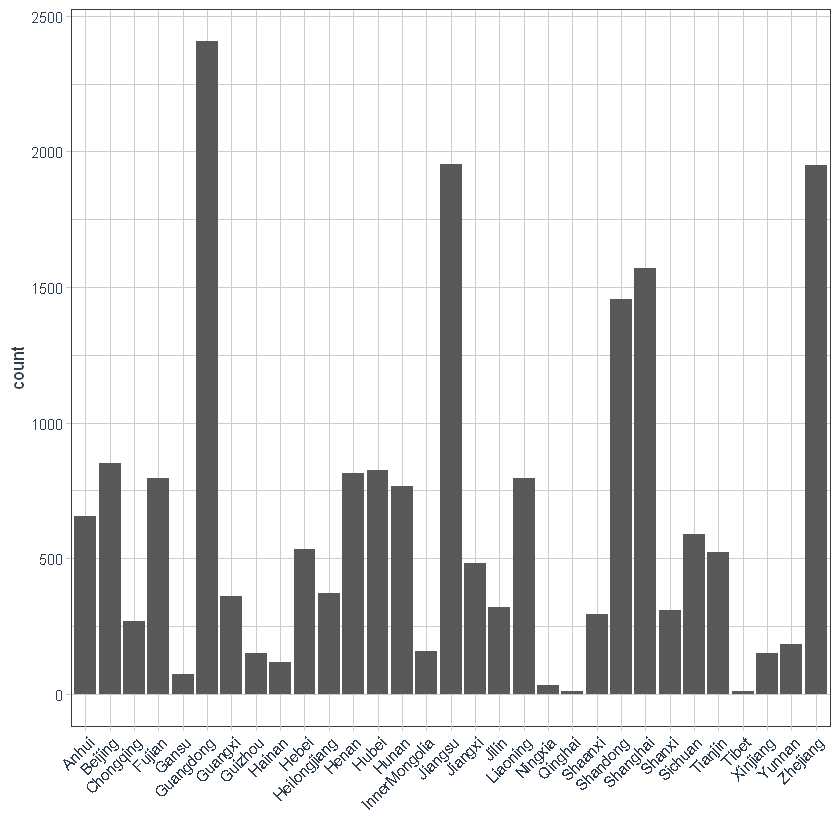

In [5]:
x1 <- dataset %>%
 ggplot(aes(country))+ geom_bar()+
 scale_fill_manual(values = palette_light()) +
 theme_tq() +
 theme(legend.position = "right") +
 theme(axis.text.x = element_text(angle = 45, vjust = 1, hjust = 1)) +
 labs(x = "",
  fill = "")
x1

Transactions over time
- To get an idea of the number of transactions over time, we can use a frequency polygon. Here, we can see that the number purchases slightly increased during the last two months of recording, while the number of returns remained relatively stable.

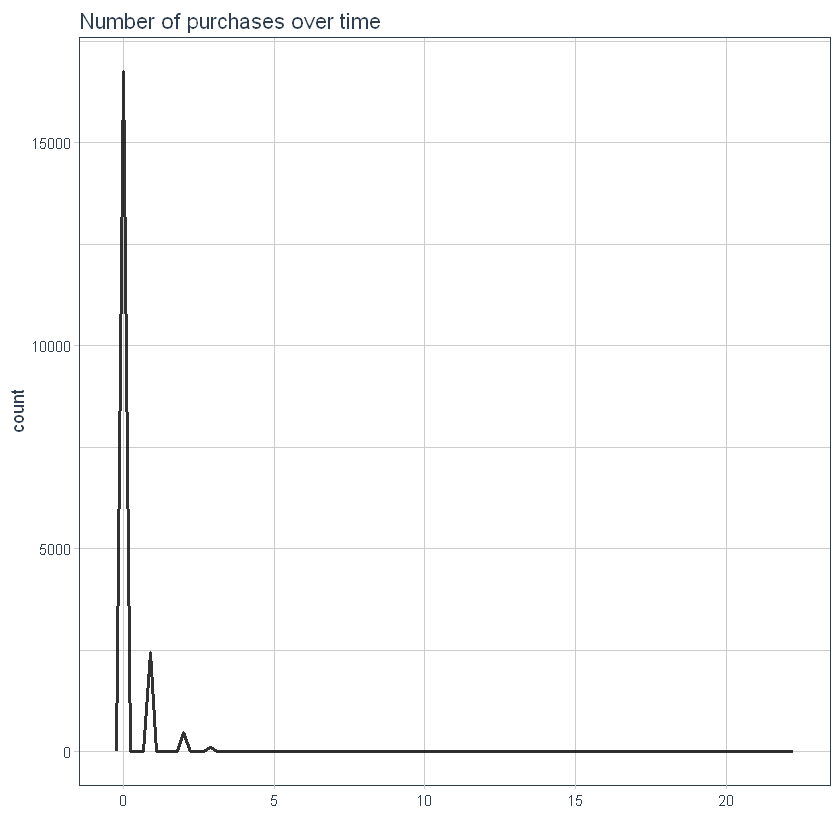

In [6]:
x2 <- dataset %>%
 ggplot(aes(x = order_hour)) +
 geom_freqpoly(bins = 100, size = 1, alpha = 0.8) +
 scale_color_manual(values = palette_light()) +
 theme_tq() +
 guides(color = FALSE) +
 labs(title = "Number of purchases over time",
  x = "")
x2

Income/loss from transactions
- Let’s look at the income/loss from transactions over time. Here, we plot the sum of income and losses for each day. The income seems to increase slightly during the last month, while losses remained more stable. The only severe outlier is the last day.

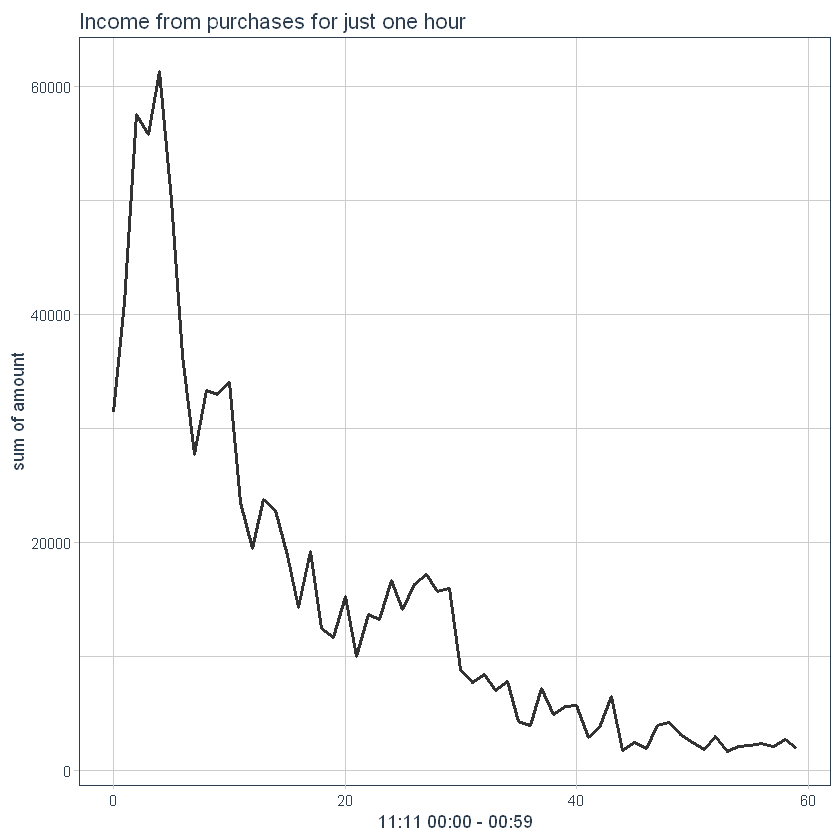

In [7]:
x3 <- dataset %>%
 filter(order_hour==0) %>% 
 group_by(order_min) %>%
 summarise(Total_amount = sum(SumPurchases)) %>%
 ggplot(aes(x = order_min, y = Total_amount)) +
 geom_line(size = 1, alpha = 0.8) +
 scale_color_manual(values = palette_light()) +
 theme_tq() +
 guides(color = FALSE) +
 labs(title = "Income from purchases for just one hour",
  x = "11:11 00:00 - 00:59",
  y = "sum of amount",
  color = "")
x3

Transactions by day and time

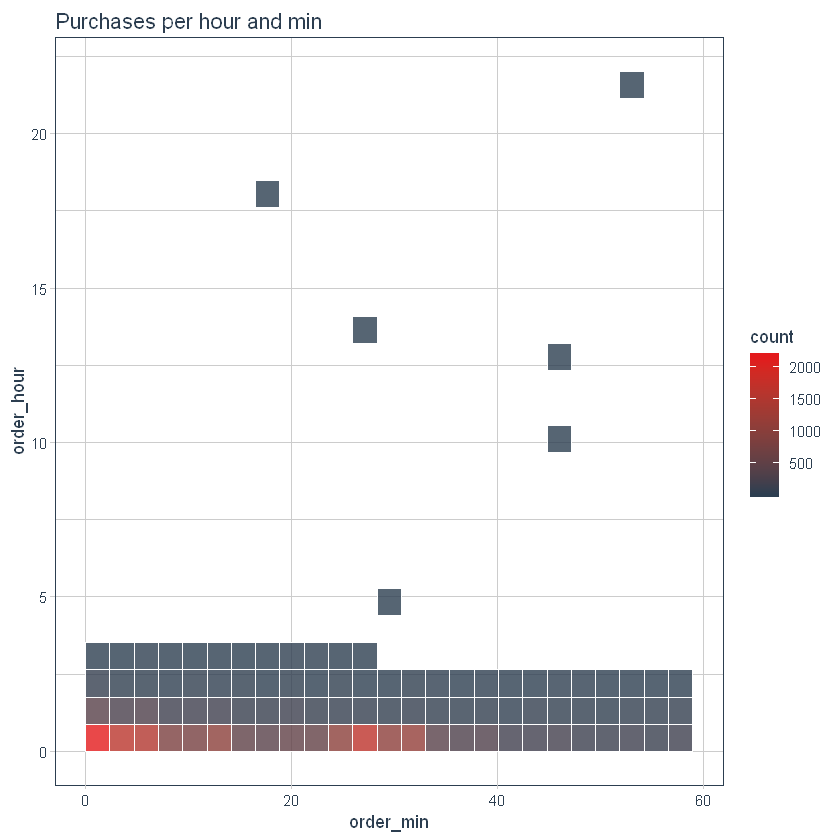

In [8]:
x4 <- dataset %>%
 ggplot(aes(x = order_min, y = order_hour)) +
 stat_bin2d(alpha = 0.8, bins = 25, color = "white") +
 scale_fill_gradientn(colours = c(palette_light()[[1]], palette_light()[[2]])) +
 theme_tq() +
 theme(legend.position = "right") +
 labs(title = "Purchases per hour and min")
x4

Items ; Also of interest are the items that are being purchases the most. Here, we sum up the net quantities for each item.

In [15]:
dataset %>% 
 group_by(stock_code, description) %>% 
 summarise(sum = sum(quantity)) %>% 
 arrange(-sum) %>% 
 head(20)

stock_code,description,sum
5.96291e+11,윤고 더 퍼스트 400ml+50ml(신)_기획,5210
5.47073e+11,테크 울드라이 1300ML,3752
5.37183e+11,테크 울드라이 용기 1500ML 세탁세제,3724
5.37297e+11,페리오 토탈 7 마일드 120g,2256
5.40352e+11,FiJi시트세제 30매*2,1897
5.98468e+11,온)보타니크 바디워시 레몬&노니 500mL,1185
5.42578e+11,죽염 잇몸고 펌프 치약 285g*2+V죽염 칫솔 잇몸전문 2+1입_베,999
5.50601e+11,RE닥터그루트 지성두피용 샴푸 400ml+ RE닥터그루트 지성두피용 200ml 증정,844
5.86269e+11,염모제 스마트염색(원터치)_자연갈색,500
5.72042e+11,죽염 히말라야 플로럴민트 100g,472


As we can see in the plots below, the majority of items is purchases only occasionally, while a few items are purchased a lot.

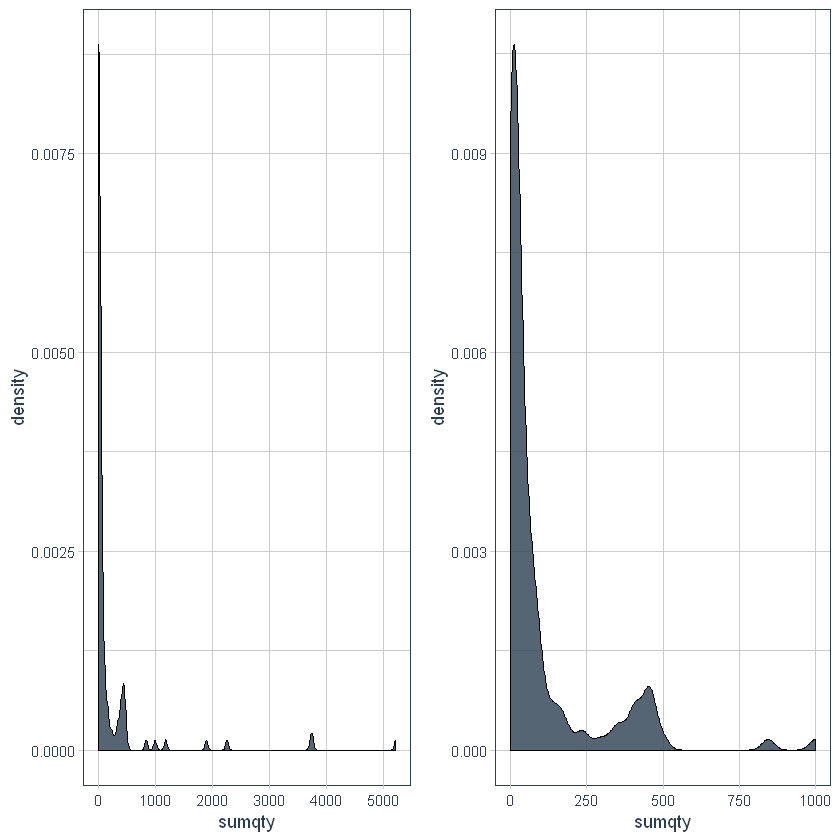

In [27]:
p1 <- dataset %>%
 group_by(stock_code, description) %>% 
 summarise(sumqty = sum(quantity)) %>% 
 ggplot(aes(x = sumqty)) +
 geom_density(fill = palette_light()[[1]], alpha = 0.8) +
 theme_tq()

p2 <- dataset %>%
 group_by(stock_code, description) %>% 
 summarise(sumqty = sum(quantity)) %>% 
 filter(sumqty>0 & sumqty<1000) %>%
 ggplot(aes(x = sumqty)) +
 geom_density(fill = palette_light()[[1]], alpha = 0.8) +
 theme_tq()

grid.arrange(p1, p2, widths = c(0.5, 0.5))

We can also calculate on how many different hours, items have been purchased.

In [30]:
most_sold <- dataset %>%
 group_by(order_hour, stock_code, description) %>%
 summarise(sum = sum(quantity)) %>%
 group_by(order_hour,description) %>%
 arrange(order_hour,-sum)
head(most_sold,5)
least_sold <- dataset %>%
 group_by(order_hour, stock_code, description) %>%
 summarise(sum = sum(quantity)) %>%
 group_by(order_hour,description) %>%
 arrange(order_hour,-sum)
tail(most_sold,5)

order_hour,stock_code,description,sum
0,5.47073e+11,테크 울드라이 1300ML,3426
0,5.37183e+11,테크 울드라이 용기 1500ML 세탁세제,3398
0,5.96291e+11,윤고 더 퍼스트 400ml+50ml(신)_기획,3025
0,5.37297e+11,페리오 토탈 7 마일드 120g,2154
0,5.40352e+11,FiJi시트세제 30매*2,1694


order_hour,stock_code,description,sum
10,5.73353e+11,온)플)아이리스 바디워시500g_12입(y16),1
13,5.49272e+11,귀애랑 중형 18P*3+ON 12P*1 + 슈퍼롱 10P*1 + 소형 *1,1
14,5.58186e+11,행복 가득 E 1호(A7),1
18,5.40352e+11,오가니스트 발효초 샴푸 500ml,1
22,5.40352e+11,오가니스트 체리불러썸 샴푸500ml+오가니스트 체리불러썸 컨디500ml+오가)로즈마리&민트샴푸200ML,1


Let’s look at Yungo & Tech's distribution of sold quantities per day

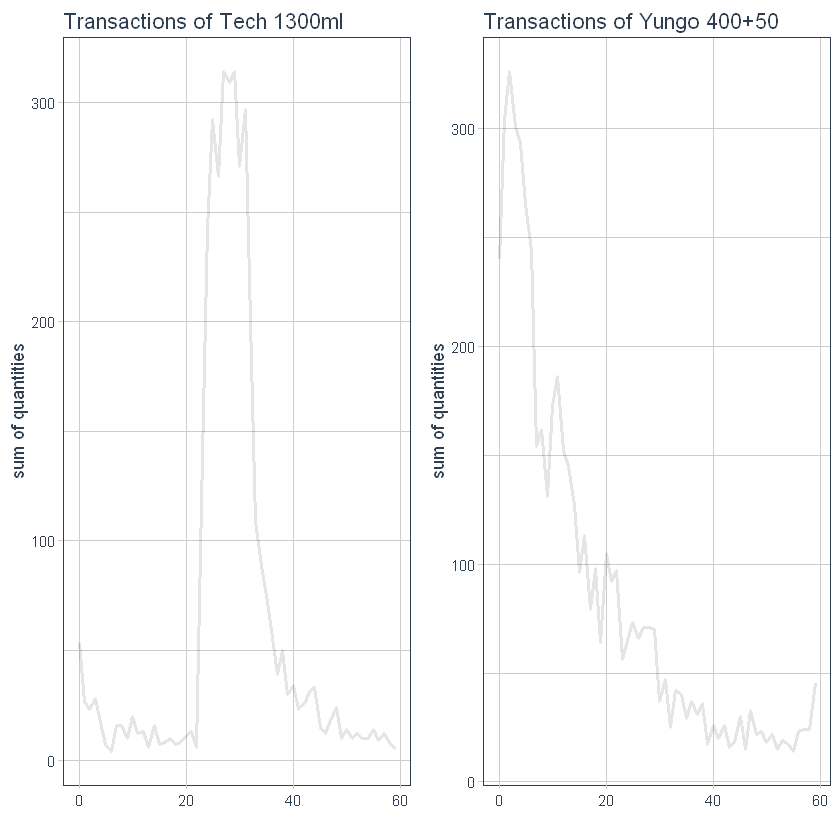

In [31]:
x5 <- 
dataset %>%
 filter(stock_code == 547073000000) %>%
 group_by(order_min) %>%
 summarise(sum = sum(quantity)) %>%
 ggplot(aes(x = order_min, y = sum)) +
 geom_line(size = 1, alpha = 0.1) +
 scale_color_manual(values = palette_light()) +
 theme_tq() +
 labs(x = "",
  y = "sum of quantities",
  color = "",
  title = "Transactions of Tech 1300ml")

x6 <- 
 dataset %>%
 filter(stock_code == 596291000000) %>%
 group_by(order_min) %>%
 summarise(sum = sum(quantity)) %>%
 ggplot(aes(x = order_min, y = sum)) +
 geom_line(size = 1, alpha = 0.1) +
 scale_color_manual(values = palette_light()) +
 theme_tq() +
 labs(x = "",
  y = "sum of quantities",
  color = "",
  title = "Transactions of Yungo 400+50")

grid.arrange(x5, x6, widths = c(0.5, 0.5))